### 1. Diet dataset - 분산 분석의  full process 적용 및 결과 해석  (다이어트 효과 분석) 

## config

In [136]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

 <br>

## Load data

In [137]:
data = pd.read_csv("../data/diet.csv")
data

,gender,Diet,weight,weight6weeks
0,M,B,60,60.0
1,M,B,103,103.0
2,F,A,58,54.2
3,F,A,60,54.0
4,F,A,64,63.3
...,...,...,...,...
73,M,C,83,80.2
74,M,C,84,79.9
75,M,C,85,79.7
76,M,C,87,77.8


 <br>

## EDA (Exploratory Data Analysis)

In [138]:
data.info()
# 결측치 X
# "gender", "diet" Dtype 변경 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        78 non-null     object 
 1   Diet          78 non-null     object 
 2   weight        78 non-null     int64  
 3   weight6weeks  78 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ KB


In [139]:
data.describe()

,weight,weight6weeks
count,78.000000,78.000000
mean,72.525641,68.680769
std,8.723344,8.924504
min,58.000000,53.000000
25%,66.000000,61.850000
50%,72.000000,68.950000
75%,78.000000,73.825000
max,103.000000,103.000000


 <br>

## Preprocessing

In [140]:
# "gender","Diet" Dtype 변경 (object -> category)
data["gender"] = data["gender"].astype("category")
data["Diet"] = data["Diet"].astype("category")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gender        78 non-null     category
 1   Diet          78 non-null     category
 2   weight        78 non-null     int64   
 3   weight6weeks  78 non-null     float64 
dtypes: category(2), float64(1), int64(1)
memory usage: 1.7 KB


In [141]:
# 파생변수 생성: 6주 후 체중 감소량(weight6weeks - weight)
# 반응변수(효과)로 사용
data["change"] = data["weight6weeks"] - data["weight"]
data

,gender,Diet,weight,weight6weeks,change
0,M,B,60,60.0,0.0
1,M,B,103,103.0,0.0
2,F,A,58,54.2,-3.8
3,F,A,60,54.0,-6.0
4,F,A,64,63.3,-0.7
...,...,...,...,...,...
73,M,C,83,80.2,-2.8
74,M,C,84,79.9,-4.1
75,M,C,85,79.7,-5.3
76,M,C,87,77.8,-9.2


In [142]:
print(data["change"].describe())
# 3가지 다이어트 결과 모두, 평균적으로 3.84kg 감량
# max: 2.1kg으로 오히려 증가한 case 존재

count    78.000000
mean     -3.844872
std       2.551478
min      -9.200000
25%      -5.550000
50%      -3.600000
75%      -2.000000
max       2.100000
Name: change, dtype: float64


 <br>

## Data Analysis

#### 분산분석 가정
- 독립성: 자료의 추출은 독립적으로 이루어졌음
- 정규성: 자료의 모집단 분포는 정규분포를 따름
- 등분산성: 모든 집단의 모분산은 동일함

In [143]:
# 정규성 검정: shapiro test(귀무가설: 정규분포를 따른다.)

def shapiro_test(data):
    stat, p = scipy.stats.shapiro(data)
    print(f"Shapiro-Wilk Test: stat: {stat}, p-value: {p}")
    if p < 0.05:
        print("귀무가설 기각(유의수준: 0.05), 따라서 정규성을 충족하지 않음")
    else:
        print("귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 정규성 충족\n")

shapiro_test(data.change[data.Diet=="A"])
shapiro_test(data.change[data.Diet=="B"])
shapiro_test(data.change[data.Diet=="C"])

Shapiro-Wilk Test: stat: 0.9255313246138968, p-value: 0.07748633505906972
귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 정규성 충족

Shapiro-Wilk Test: stat: 0.9855912340453256, p-value: 0.9611748496261021
귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 정규성 충족

Shapiro-Wilk Test: stat: 0.9601254566120733, p-value: 0.3720400277004393
귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 정규성 충족



In [144]:
# 등분산성 검정: levene test(귀무가설: 등분산성을 만족한다.)
from scipy.stats import levene

stat, p = levene(data.change[data.Diet=="A"], data.change[data.Diet=="B"], data.change[data.Diet=="C"])
print(f"Levene Test: stat: {stat}, p-value: {p}")

if p < 0.05:
    print("귀무가설 기각(유의수준: 0.05), 따라서 등분산성을 충족하지 않음")
else:
    print("귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 등분산성 충족\n")

Levene Test: stat: 0.6256665777896312, p-value: 0.5376731304274011
귀무가설을 기각할 수 없음(유의수준: 0.05), 따라서 등분산성 충족



##### 독립성을 충족한다는 가정하에, 정규성과 등분산성을 충족하므로 일원분산분석을 시행한다.

 <br>

#### 일원분류 분산분석
- 귀무가설: 다이어트 유형에 따른 체중 변화에는 유의미한 차이가 없다.
- 대립가설: 다이어트 유형에 따른 체중 변화에는 <strong>유의미한 차이가 있다.</strong>

In [145]:
data

,gender,Diet,weight,weight6weeks,change
0,M,B,60,60.0,0.0
1,M,B,103,103.0,0.0
2,F,A,58,54.2,-3.8
3,F,A,60,54.0,-6.0
4,F,A,64,63.3,-0.7
...,...,...,...,...,...
73,M,C,83,80.2,-2.8
74,M,C,84,79.9,-4.1
75,M,C,85,79.7,-5.3
76,M,C,87,77.8,-9.2


In [146]:
# Diet에 따른 6주 후 체중변화량 분석 (통계)

data.groupby('Diet').agg({"change": ["mean", "std", "min", "max"]})

# Diet C의 평균 체중 감량량이 가장 큼
# Diet C를 제외한 나머지 Diet는 오히려 증가한 경우도 존재

change                    
          mean       std  min  max
Diet                              
A    -3.300000  2.240148 -9.0  0.6
B    -3.025926  2.523367 -7.9  2.1
C    -5.148148  2.395568 -9.2 -0.5

In [147]:
# Diet에 따른 6주 후 체중변화량 분석 (일원분류 분산분석)

formula = "change ~ Diet"   # 반응변수 ~ 설명변수
data_fit = smf.ols(formula=formula, data=data).fit()    # 모델 적합
anova_table = sm.stats.anova_lm(data_fit, typ=3)    # 분산분석표 생성
anova_table

,sum_sq,df,F,PR(>F)
Intercept,261.360000,1.0,45.567050,2.717251e-09
Diet,71.093689,2.0,6.197447,3.229014e-03
Residual,430.179259,75.0,NaN,NaN


- F통계량 약 6.2로 다이어트별 그룹 간 변화량의 차이가 있다.
- P-value 약 0.003으로 유의함 (유의수준: 0.05)

<br>

따라서,
- 귀무가설(H0: "다이어트 유형에 따른 체중 변화에는 유의미한 차이가 없다.") 기각
- 대립가설(H1: "다이어트 유형에 따른 체중변화에는 차이가 있다.") 채택
- 결론: 다이어트 유형에 따른 체중변화에는 차이가 있다.

 <br>

### 사후분석 - 다중비교

In [148]:
# Tukey's HSD Test: 다중비교

comp = mc.MultiComparison(data["change"], data["Diet"])   # 다중비교
post_hoc_res = comp.tukeyhsd(alpha=0.05)   # Tukey's HSD Test
print(post_hoc_res)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B   0.2741 0.9125 -1.3325  1.8806  False
     A      C  -1.8481 0.0201 -3.4547 -0.2416   True
     B      C  -2.1222 0.0048 -3.6808 -0.5636   True
----------------------------------------------------


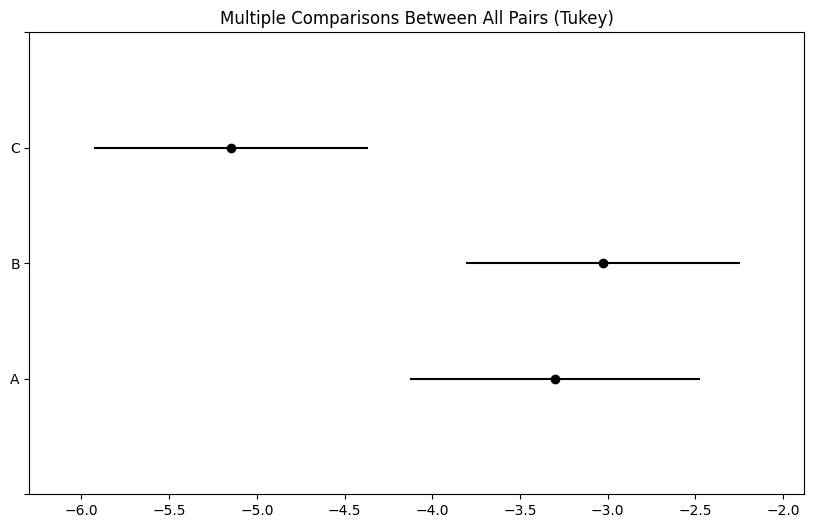

In [149]:
fig = post_hoc_res.plot_simultaneous()    # 시각화
plt.show()

- A vs B: 평균차이 약 0.27, p-value는 약 0.9(귀무가설 채택),  A와 B의 체중변화량은 차이가 없다.
- A vs C: 평균차이 약 3.5, p-value는 약 0.02(귀무가설 기각), A와 C의 체중변화량은 차이가 있다. (C가 더 많이 감량)
- B vs C: 평균차이 약 3.2, p-value는 약 0.004(귀무가설 기각), B와 C의 체중변화량은 차이가 있다. (C가 더 많이 감량)

#### 결론
- Diet C의 체중변화량이 가장 큼
- Diet A와 B는 체중변화량에 차이가 없음

 <br>

#### 이원분류 분산분석

In [ ]:
formula = 'change ~ C(gender) + C(Diet) + C(gender):C(Diet)'    # 상호작용효과 추가
data_fit = smf.ols(formula=formula, data=data).fit()    # 모델 적합
anova_table = sm.stats.anova_lm(data_fit, typ=3)    # 분산분석표 생성
print(anova_table)

                       sum_sq    df          F    PR(>F)
Intercept          130.235000   1.0  23.158434  0.000008
C(gender)            2.100000   1.0   0.373423  0.543069
C(Diet)             92.319621   2.0   8.208154  0.000615
C(gender):C(Diet)   25.140704   2.0   2.235264  0.114336
Residual           404.903029  72.0        NaN       NaN


- C(gender):
    - F통계량 약 0.37, P-value 약 0.54로, 성별에 따른 체중 변화에는 유의미한 차이가 없다.

- C(Diet):
    - F통계량 약 8.2, P-value 약 0.0006으로, 다이어트 유형에 따라 체중 변화에는 유의미한 차이가 있다.

- C(gender) : C(Diet):
    - F통계량 약 2.2, P-value 약 0.11로, 성별과 다이어트 유형 간 상호작용이 체중변화에 유의미한 영향이 없다.

#### 결론
- 다이어트 유형에 따라 체중 변화에 유의미한 차이가 있다.
- 성별 자체는 체중 변화에 유의미한 영향이 없다.
- 셩별과 다이어트 유형 간 상호작용에는 체중 변화에 유의미한 영향이 없다.